In [1]:
import warnings
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from jqdata import get_trade_days
from tqdm import tqdm_notebook
import statsmodels.api as sm
from sklearn import linear_model

warnings.filterwarnings('ignore')

In [4]:
def avg(lst): 
    return sum(lst) / len(lst)

def MaxDrawdown(return_list):
    a = np.maximum.accumulate(return_list)
    l = np.argmax((np.maximum.accumulate(return_list) - return_list) /np.maximum.accumulate(return_list))
    k = np.argmax(return_list[:l])
    return (return_list[k] - return_list[l])/(return_list[l])

In [111]:
start_date = '2018-03-08'
end_date = '2019-08-09'
date_list = get_trade_days(start_date, end_date)
range_1 = []
volume = []
m_draw = []
volatility = []
for date in tqdm_notebook(date_list):
    start_time = '%s 9:30:0' % date.strftime('%Y-%m-%d')
    end_time = '%s 15:0:0' % date.strftime('%Y-%m-%d') 
    min_price_df = get_price('000842.XSHG', start_time, end_time, '5m', ['open', 'close', 'low', 'high','volume'])
    #振幅
    rang = (min_price_df['high']-min_price_df['low']).tolist()
    range_1.append(avg(rang))
    #volume
    min_price_df['vol_d'] = min_price_df['volume'].shift()/min_price_df['volume']-1
    vol =  min_price_df['vol_d'].dropna().tolist()
    volume.append(avg(vol))
    #最大回撤率
    close_price = min_price_df['close'].tolist()
    m_range = MaxDrawdown(close_price)
    #m_range = np.sqrt(m_range)
    m_draw.append(m_range)
    
'''    
    # 5min vol
    close_df = get_price('000842.XSHG', start_time, end_time, '1m',fields=['close', 'pre_close'])
    close_df['pct'] = close_df['close']/close_df['pre_close']-1
    close_df['col'] = close_df['pct'].rolling(5).std()
    a = close_df['col'].dropna().tolist()
    volatility.append(avg(a))
'''    


"    \n    # 5min vol\n    close_df = get_price('000842.XSHG', start_time, end_time, '1m',fields=['close', 'pre_close'])\n    close_df['pct'] = close_df['close']/close_df['pre_close']-1\n    close_df['col'] = close_df['pct'].rolling(5).std()\n    a = close_df['col'].dropna().tolist()\n    volatility.append(avg(a))\n"

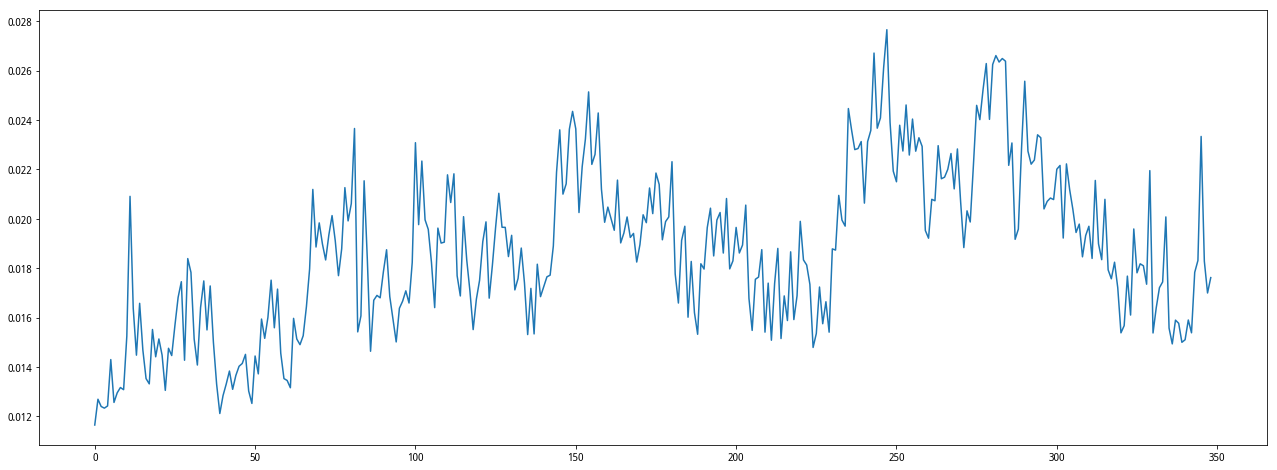

In [30]:
std_5 = []
for date in tqdm_notebook(date_list):
    start_time = '%s 9:30:0' % date.strftime('%Y-%m-%d')
    end_time = '%s 15:0:0' % date.strftime('%Y-%m-%d')
    close_df = get_price('000842.XSHG', start_time, end_time, '1m',fields=['close', 'pre_close'])
    # 计算收益率
    close_df['pct'] = (close_df['close']/close_df['pre_close'])-1

    # 计算波动率  未年化处理
    col = 'std_'+str(5)
    close_df['col'] = np.sqrt(close_df['pct'].rolling(5).std())
    a = close_df['col'].dropna().tolist()
    std_5.append(avg(a))
    
plt.figure(figsize=(22, 8))
plt.plot(std_5)


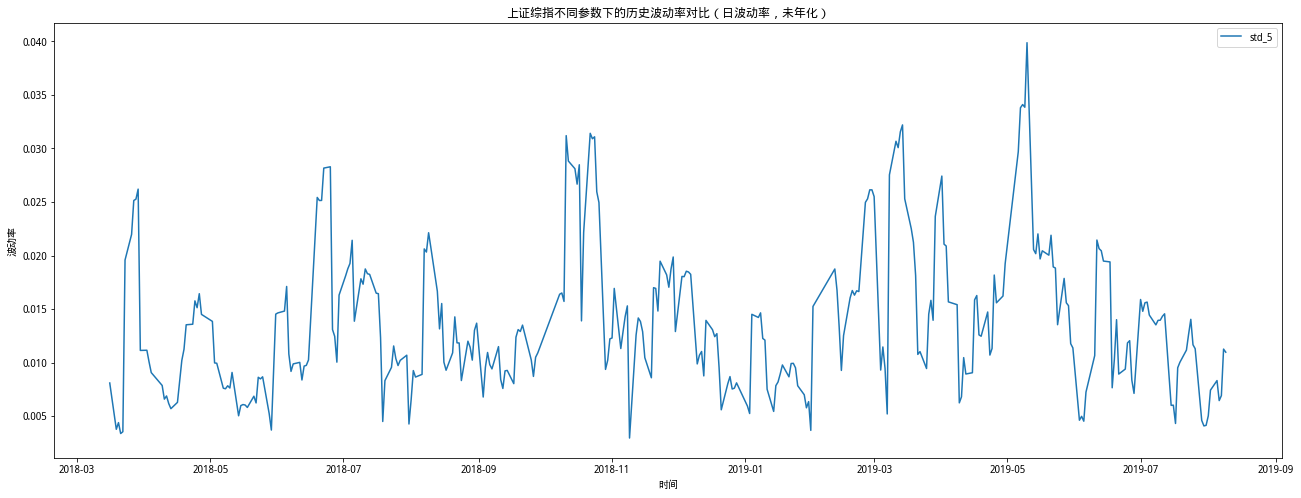

In [5]:
start = '2018-03-12'
end = '2019-08-09'
# 获取上证收盘数据
close_ = get_price('000842.XSHG', start, end, '1d',fields=['close', 'pre_close'])
# 计算收益率
close_['pct'] = close_['close']/close_['pre_close']-1
plt.figure(figsize=(22, 8))
# 计算n日波动率  未年化处理
col = 'std_'+str(5)
close_['col'] = close_['pct'].rolling(5).std()
plt.plot(close_['col'], label=col)
plt.legend(loc='best')
plt.xlabel('时间')
plt.ylabel('波动率')
plt.title('上证综指不同参数下的历史波动率对比（日波动率，未年化）')
plt.show()

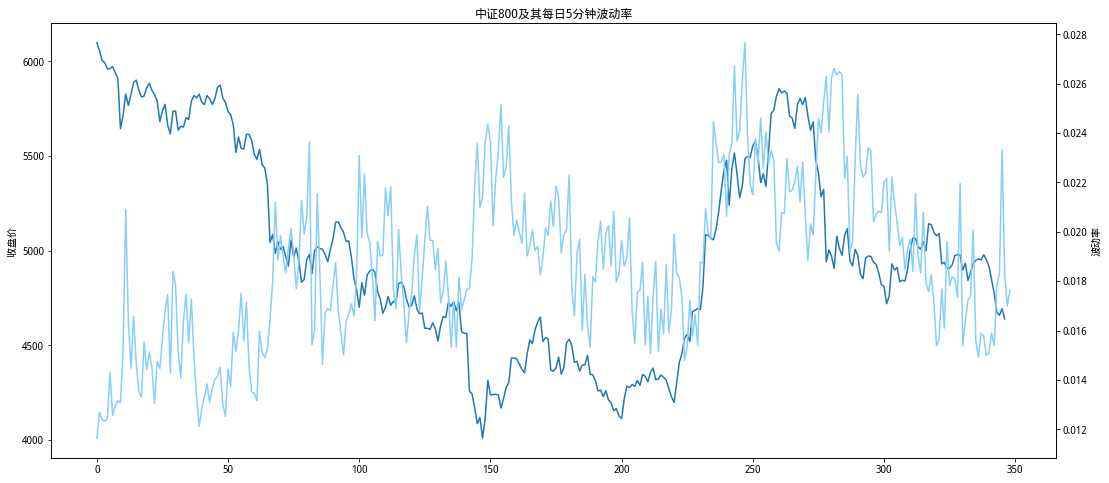

In [6]:
y1 = close_['close'].tolist()# 获取收盘数据
#y1 = ret 
#y2 = close_['col'] 
fig = plt.figure(figsize=(18, 8))  # 图表大小设置

ax1 = fig.add_subplot(111)

ax1.plot(y1)
ax1.set_ylabel('收盘价')


ax2 = ax1.twinx()  # 设置双Y轴 关键function
ax2.plot(std_5, '#87CEFA')
ax2.set_ylabel('波动率')

ax1.set_title("中证800及其每日5分钟波动率")

plt.xlabel('时间')
plt.show()

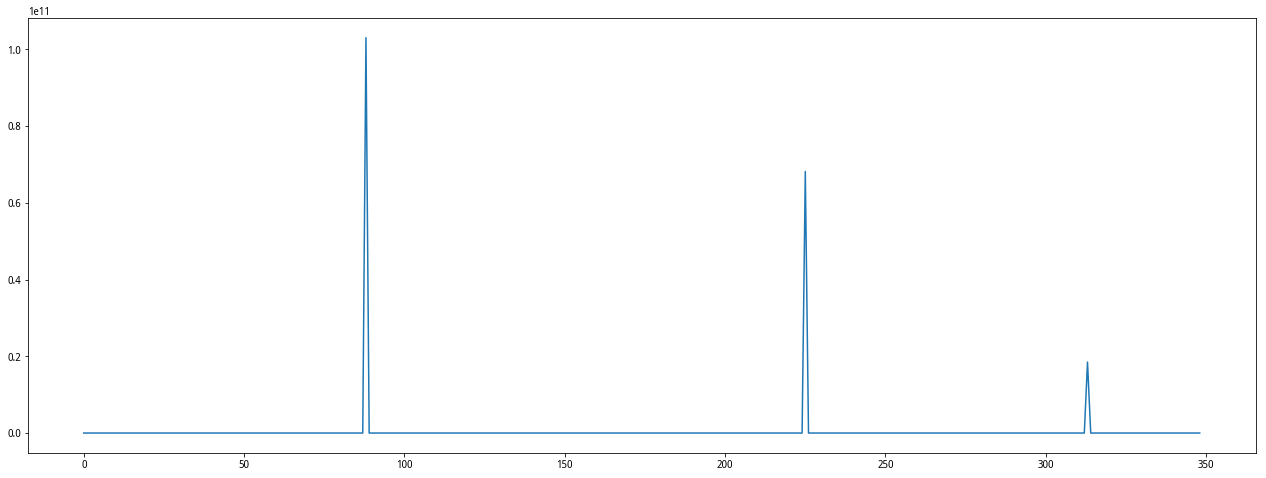

In [112]:
basis = []
for date in tqdm_notebook(date_list):
    start_time = '%s 9:30:0' % date.strftime('%Y-%m-%d')
    end_time = '%s 15:0:0' % date.strftime('%Y-%m-%d') 
    #基差
    #行情数据获取
    #输入：起止时间，返回：几个期货数据的时间序列
    pool = ['IF9999.CCFX','IC9999.CCFX']
    pool1= ['000300.XSHG','000905.XSHG']
    df = get_price(pool,start_time,end_time,'1m',fields=['close'])['close']  #获取价格信息
    df_volume = get_price(pool,start_time,end_time,'1m',fields=['volume'])['volume'] #获取成交量信息
    df1 = get_price(pool1,start_time,end_time,'1m',fields=['close'])['close']  #获取价格信息
    df_volume1 = get_price(pool1,start_time,end_time,'1m',fields=['volume'])['volume'] #获取成交量信息
    
    #将主力合约的值减去行情价格，观察差值表现
    diff_df = pd.DataFrame()
    diff_df['IF_diff'] =  df1['000300.XSHG'] - df['IF9999.CCFX']
    diff_df['IC_diff'] =  df1['000905.XSHG']- df['IC9999.CCFX']
    diff_df['total'] = diff_df['IF_diff'] + diff_df['IC_diff']
    b = diff_df['total'].shift() / diff_df['total'] - 1
    b = b.dropna().tolist()
    #print(b)
    basis.append(avg(b))
plt.figure(figsize=(22, 8))
plt.plot(basis)

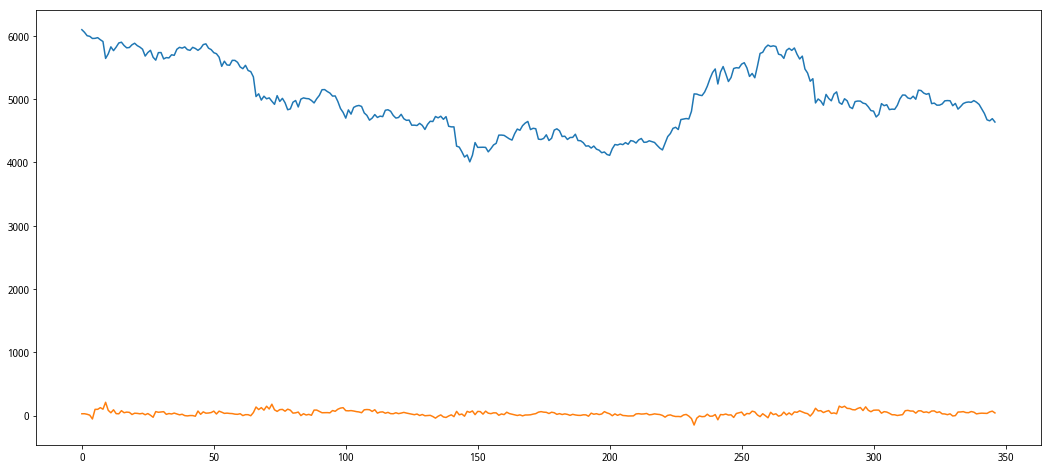

In [8]:
pool = ['IF9999.CCFX','IC9999.CCFX']
pool1= ['000300.XSHG','000905.XSHG']
df = get_price(pool,start,end,'1d',fields=['close'])['close']  #获取价格信息
df_volume = get_price(pool,start,end,'1d',fields=['volume'])['volume'] #获取成交量信息
df1 = get_price(pool1,start,end,'1d',fields=['close'])['close']  #获取价格信息
df_volume1 = get_price(pool1,start,end,'1d',fields=['volume'])['volume'] #获取成交量信息

#将主力合约的值减去行情价格，观察差值表现
diff_df = pd.DataFrame()
diff_df['IF_diff'] =  df1['000300.XSHG'] - df['IF9999.CCFX']
diff_df['IC_diff'] =  df1['000905.XSHG']- df['IC9999.CCFX']
diff_df['total'] = diff_df['IF_diff'] + diff_df['IC_diff']
b = diff_df['total'].tolist()

Text(0.5, 1.0, '沪深300指数及沪深300期货指数')

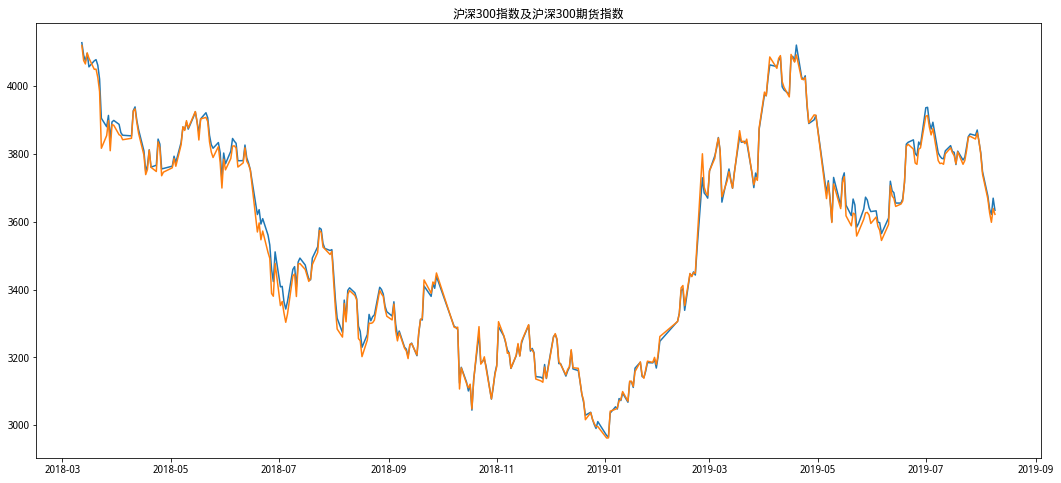

In [9]:
start = '2018-03-12'
end = '2019-08-09'
df = get_price('IF9999.CCFX',start,end,'1d',fields=['close'])['close']
df1 = get_price('000300.XSHG',start,end,'1d',fields=['close'])['close']
fig = plt.figure(figsize=(18, 8) )
plt.plot(df1)
plt.plot(df)
plt.title("沪深300指数及沪深300期货指数")

Text(0.5, 1.0, '中证500指数及中证500期货指数')

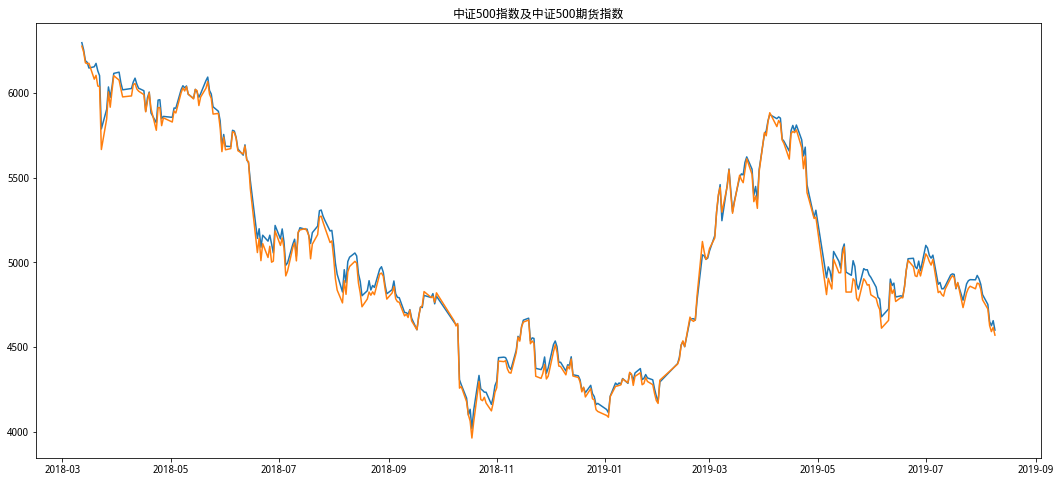

In [10]:
start = '2018-03-12'
end = '2019-08-09'
df = get_price('IC9999.CCFX',start,end,'1d',fields=['close'])['close']
df1 = get_price('000905.XSHG',start,end,'1d',fields=['close'])['close']
fig = plt.figure(figsize=(18, 8))
plt.plot(df1)
plt.plot(df)
plt.title("中证500指数及中证500期货指数")

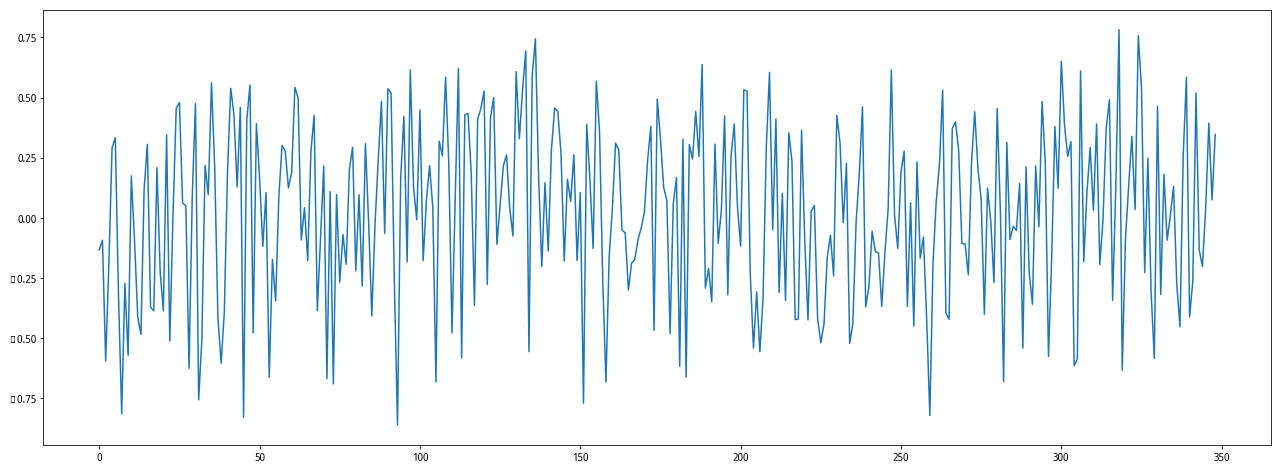

In [88]:
#5min 量价关系
def corr(start_date, end_date,symbol):
    date_list = get_trade_days(start_date, end_date)
    X = []
    for date in tqdm_notebook(date_list):
        start_time = '%s 9:30:0' % date.strftime('%Y-%m-%d')
        end_time = '%s 15:0:0' % date.strftime('%Y-%m-%d')
        price_df = get_price(symbol, start_time, end_time, '5m', ['close', 'volume'])
        # 日内5分钟量价相关性
        pv_corr = price_df.corr().values[0, 1]
        X.append(pv_corr.mean())
    return X
    
corr_list = corr(start_date,end_date,'000842.XSHG')

plt.figure(figsize=(22, 8))
plt.plot(corr_list)

In [114]:
import seaborn as sns

value_df = pd.read_excel('产品净值.xlsx', index_col=0)
value = value_df['value'].tolist()
y =  value_df.shift()/value_df - 1
ret = y['value'].tolist()
#plt.figure(figsize=(22, 8))
#plt.plot(ret)

df = {'return':value,'回撤':m_draw,'波动率':std_5,'量价关系':corr_list,'振幅':range_1,'基差':basis,'交易量':volume}
df = pd.DataFrame(df)
df = df.dropna()
#normalized_df=(df-df.mean())/df.std()
print(df.head(10))

   return        回撤       波动率      量价关系        振幅        基差       交易量
0  1.0000  0.003962  0.011648 -0.133618  4.593333  0.009263  0.018785
1  1.0001  0.001395  0.012693 -0.093474  4.373750  0.036253  0.024122
2  0.9999  0.002373  0.012399 -0.596046  4.216250 -0.027750  0.026017
3  1.0002  0.006247  0.012332 -0.192958  4.984583  0.018430  0.025777
4  1.0002  0.007946  0.012421  0.291564  4.988750  0.160285  0.030273
5  1.0004  0.011037  0.014299  0.332514  6.399792 -0.237251  0.027662
6  1.0000  0.009314  0.012564 -0.321194  4.922083 -0.359400  0.015087
7  1.0012  0.005264  0.012952 -0.815940  5.337708  0.002777  0.024313
8  1.0013  0.004833  0.013167 -0.272664  5.708958  0.001318  0.040455
9  1.0014  0.014343  0.013080 -0.572374  5.436250  0.001238  0.037295


In [127]:
X = df[['回撤', '波动率','量价关系','基差','交易量']]
Y = df[['return']]  
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso,LassoCV,LassoLarsCV
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=42)
lasso = Lasso().fit(X_train,y_train)
lasso001 =Lasso(alpha=0.01).fit(X_train,y_train)
lasso005 = Lasso(alpha=0.05).fit(X_train,y_train)
lasso00001 = Lasso(alpha=0.0001).fit(X_train,y_train)
lasso05 = Lasso(alpha=0.5).fit(X_train,y_train)
print('**********************************')
print("Lasso alpha=1")
print ("training set score:{:.2f}".format(lasso.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso.coef_!=0)))
print('**********************************')
print("Lasso alpha=0.01")
print ("training set score:{:.2f}".format(lasso001.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso001.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso001.coef_!=0)))
print('**********************************')
print("Lasso alpha=0.001")
print ("training set score:{:.2f}".format(lasso00001.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso00001.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso00001.coef_!=0)))
print('**********************************')
print("Lasso alpha=0.0001")
print ("training set score:{:.2f}".format(lasso005.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso005.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso005.coef_!=0)))
print('**********************************')
print("Lasso alpha=0.005")
print ("training set score:{:.2f}".format(lasso05.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso05.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso05.coef_!=0)))


**********************************
Lasso alpha=1
training set score:0.00
test set score:-0.01
Number of features used:1
**********************************
Lasso alpha=0.01
training set score:0.00
test set score:-0.01
Number of features used:1
**********************************
Lasso alpha=0.001
training set score:0.15
test set score:0.08
Number of features used:3
**********************************
Lasso alpha=0.0001
training set score:0.00
test set score:-0.01
Number of features used:1
**********************************
Lasso alpha=0.005
training set score:0.00
test set score:-0.01
Number of features used:1


            回撤       波动率      量价关系        振幅        基差       交易量
回撤    1.000000  0.555638  0.203362  0.625427 -0.039673  0.483810
波动率   0.555638  1.000000  0.041092  0.849695 -0.053843  0.730877
量价关系  0.203362  0.041092  1.000000 -0.044540  0.011671  0.035170
振幅    0.625427  0.849695 -0.044540  1.000000 -0.054832  0.590795
基差   -0.039673 -0.053843  0.011671 -0.054832  1.000000 -0.040917
交易量   0.483810  0.730877  0.035170  0.590795 -0.040917  1.000000


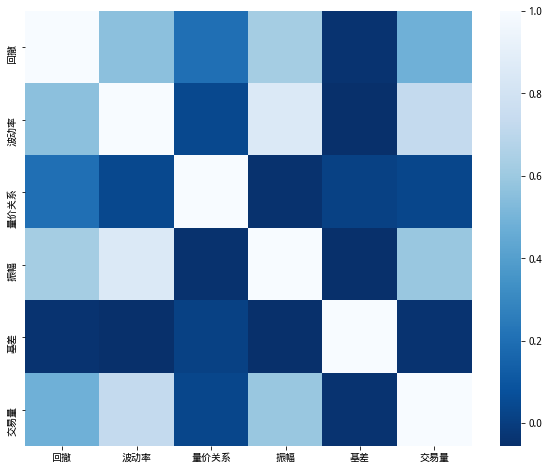

In [106]:
#correlation matrix 
plt.figure(figsize=(10, 8))
corr_matrix = df[['回撤', '波动率','量价关系','振幅','基差','交易量']].corr()
print(corr_matrix)
sns.heatmap(corr_matrix,cmap="Blues_r")
plt.show()

In [130]:
from sklearn.linear_model import Ridge
### 建立岭回归实例
ridge01 = Ridge(alpha=0.01).fit(X_train,y_train)
print("Training set score:{}".format(ridge01.score(X_train,y_train)))
print("ridge.coef_: {}".format(ridge01.coef_))
print("ridge.intercept_: {}".format(ridge01.intercept_))

Training set score:0.18285282842015893
ridge.coef_: [[0.518471687545516 -0.0021203347084109364 2.5636313367190173e-14
  0.9849868000586696]]
ridge.intercept_: [1.0063846326755759]


In [107]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices("df['return'] ~ df['波动率'] + df['回撤']+ df['量价关系'] + df['基差'] + df['交易量']", data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
print(vif)

            VIF    variable
0  5.893778e-20   Intercept
1  9.673504e-20   df['波动率']
2  1.452493e-18    df['回撤']
3  1.303017e-21  df['量价关系']
4  1.000155e+00    df['基差']
5  2.954205e-19   df['交易量']


In [108]:
from statsmodels.formula.api import ols

a = ols("df['return'] ~ df['波动率'] + df['回撤']+ df['量价关系'] + df['基差'] + df['交易量']", data = df).fit()
a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:           df['return']   R-squared:          -17920091527477366469165056.000
Model:                            OLS   Adj. R-squared:     -18181317351493073316610048.000
Method:                 Least Squares   F-statistic:                                 -68.60
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                            1.00
Time:                        15:49:00   Log-Likelihood:                             -9538.3
No. Observations:                 349   AIC:                                      1.909e+04
Df Residuals:                     343   BIC:                                      1.911e+04
Df Model:                           5                                                      
Covariance Type:            nonrobust                                                      
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1789   4.73e+11   2.49e-12      1.000    -9.3e+11     9.3e+11
df['波动率']    -13.7111   3.71e+12  -3.69e-12      1.000    -7.3e+12     7.3e+12
df['回撤']     152.6692   2.86e+12   5.35e-11      1.000   -5.62e+12    5.62e+12
df['量价关系']    12.3997   1.02e+12   1.21e-11      1.000   -2.02e+12    2.02e+12
df['基差']      26.7874   4.32e+11    6.2e-11      1.000    -8.5e+11     8.5e+11
df['交易量']    -44.2866   1.79e+12  -2.48e-11      1.000   -3.52e+12    3.52e+12
==============================================================================
Omnibus:                      702.701   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           523281.211
Skew:                         -13.469   Prob(JB):                         0.00
Kurtosis:                     190.774   Cond. No.                     3.22e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [109]:
model = sm.OLS(df['return'],df['振幅']).fit()
print(model.summary())

model1 = sm.OLS(df['return'],df['回撤']).fit()
print(model1.summary())

model2 = sm.OLS(df['return'],df['波动率']).fit()
print(model2.summary())

model3 = sm.OLS(df['return'],df['量价关系']).fit()
print(model3.summary())

model4 = sm.OLS(df['return'],df['基差']).fit()
print(model4.summary())

model5 = sm.OLS(df['return'],df['交易量']).fit()
print(model5.summary())

# fit linear regression
#f = df[['回撤','波动率','量价关系','基差']]
#model5 = sm.OLS(df['return'],f).fit()
#print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:                 return   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     2663.
Date:                Sun, 13 Sep 2020   Prob (F-statistic):          4.05e-165
Time:                        15:49:07   Log-Likelihood:                -140.05
No. Observations:                 349   AIC:                             282.1
Df Residuals:                     348   BIC:                             286.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
振幅             0.1215      0.002     51.600      0.0

In [113]:
X = df[['回撤', '波动率','量价关系','振幅','基差','交易量']]
Y = df[['return']]  
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y,random_state=42)
lasso = Lasso().fit(X_train,y_train)
print('**********************************')
print("Lasso alpha=1")
print ("training set score:{:.2f}".format(lasso.score(X_train,y_train)))
print ("test set score:{:.2f}".format(lasso.score(X_test,y_test)))
print ("Number of features used:{}".format(np.sum(lasso.coef_!=0)))

KeyError: '[回撤 波动率 量价关系 振幅 基差 交易量] not in index'

In [110]:
# fit linear regression
f = df[['波动率','量价关系','基差']]
model = sm.OLS(df['return'],f).fit()
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:                 return   R-squared:          -811537356678749056.000
Model:                            OLS   Adj. R-squared:     -818573807748217984.000
Method:                 Least Squares   F-statistic:                         -115.3
Date:                Sun, 13 Sep 2020   Prob (F-statistic):                    1.00
Time:                        15:49:22   Log-Likelihood:                     -7712.5
No. Observations:                 349   AIC:                              1.543e+04
Df Residuals:                     346   BIC:                              1.544e+04
Df Model:                           3                                              
Covariance Type:            nonrobust                                              
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
波动